# Classification of 'CryptoCurrency' and 'Stocks' Subreddits

# Part 3: Data Modeling and Conclusion

### Contents
1. [Data Modeling](#1.-Data-Modeling)
2. [Conclusion and Recommendations](#2.-Conclusion-and-Recommendations)

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, plot_roc_curve, recall_score

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

In [2]:
# import dataframe
df = pd.read_pickle('../datasets/final')

In [3]:
# display first 5 rows
df.head()

,subreddit,upvote_ratio,text,text_adj,token
0,CryptoCurrency,1.0,Media is bullish again,media is bullish again,"[medium, bullish]"
1,CryptoCurrency,1.0,Half of All Bitcoin Open Interest on CME Set t...,half of all bitcoin open interest on cme set t...,"[half, bitcoin, open, interest, cme, set, expi..."
2,CryptoCurrency,1.0,BBC release Doctor Who trading cards using NFT...,bbc release doctor who trading cards using nft...,"[bbc, release, doctor, trading, card, using, n..."
3,CryptoCurrency,1.0,What's going on with bitcoin prehalving????,what is going on with bitcoin prehalving????,"[going, bitcoin, prehalving]"
4,CryptoCurrency,1.0,Quantum Financial Reset To A 3D/5D Hybrid Stat...,quantum financial reset to a 3d/5d hybrid stat...,"[quantum, financial, reset, 3, 5, hybrid, stat..."


In [ ]:
# map CryptoCurrency = 1 and stocks = 0

df['label'] = df['subreddit'].map({'CryptoCurrency': 1, 'stocks': 0})

## 1. Data Modeling

Because the goal of this project is to be able to predict whether a post belongs to r/CryptoCurrency or not, I will map r/CryptoCurrency as True and r/stocks as False

This means that:
 * True Positives are posts that my model correctly predicts are from r/CryptoCurrency
 * True Negatives are posts that my model correctly predicts are from r/stocks
 * False Positves are posts that my model incorrectly predicts are from r/CryptoCurrency (but are actually from r/stocks)
 * False Negatives are posts that my model incorrectly predicts are from r/stocks (but are actually from r/CryptoCurrency)

The purpose of this project is to be able to target CryptoGo's marketing campaign to more users on reddit that are interested in cryptocurrency. Therefore, I want to focus on minimizing my False Negative rate, because I want to ensure I target all posts that may be related to cryptocurrency, even if this means I accidentally market to some users who are not interested in cryptocurrency
At the same time, I do not want to target every post across reddit regardless of interest in cryptocurrency because this would quickly become expensive. Hence, I will use the F1 score to ensure my true positives and true negatives are relatively low.

I wil train multiple models including a baseline model, Random Forest Classifier, Multinomial Naive Bayes, and Support Vector Classifier to select my best performing model.

I will use the following metrics to build and evaluate my models:
- F1 score: I will compare the F1 scores of my train, test, and cross validation sets to see if my model is overfitting or underfitting
- Recall: I will tune my hyperparameters using recall to minimize my False Negative Rate
- ROC AUC, Recall, and F1 score: I will use these three metrics to compare the performance of my models on the test set so that I can select a model that performs well on all three criterias and deliver a final model with an F1 score and sensitivity above 90%



In [5]:
# drop columns except text_adj and label
df.drop(['subreddit', 'text', 'token', 'upvote_ratio'], axis = 1, inplace = True)

In [6]:
# train test split
X = df['text_adj']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

In [31]:
# define functions for modeling

# compare F1 scores
def display_f1(model, X_train, y_train, X_test, y_test):
    print('Train F1 Score: ', round(f1_score(y_train, model.predict(X_train)),5))
    print('Test F1 Score: ', round(f1_score(y_test, model.predict(X_test)),5))
    print('Cross Val F1 Score:', round(cross_val_score(model, X_test,y_test, scoring = 'f1').mean(),5))
    
# plot ROC and Confusionn matrix
def plot_model(model, X_test, y_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    
    #Plot ROC curve
    ax1.set_title('ROC Curve')
    plot_roc_curve(model, X_test, y_test, ax = ax1)
    ax1.plot([0, 1], [0, 1],label='baseline', linestyle='--')
    ax1.legend()

    #Plot confusion matrix
    ax2.set_title('Confusion Matrix')
    y_labeled = y_test.map({1:'CryptoCurrency', 0:'Stocks'})
    y_pred = pd.Series(model.predict(X_test)).map({1:'CryptoCurrency', 0:'Stocks'})
    cm = confusion_matrix(y_labeled, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax2, cmap='Blues')
    ax2.set_xlabel('Predicted labels')
    ax2.set_ylabel('True labels')
    ax2.xaxis.set_ticklabels(['CryptoCurrency', 'Stocks']) 
    ax2.yaxis.set_ticklabels(['CryptoCurrency', 'Stocks'])
    plt.show();

# model comparisons
def add_model(name, model, X_test, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    
    model_dictionary[name] = [round(f1_score(y_test, model.predict(X_test)),5), #F1 score
                              round(recall_score(y_test, model.predict(X_test)),5), #Recall 
                              round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),5), #ROC AUC 
                              tp, #True Positive
                              fp, #False Positive
                              tn, #True Negative
                              fn #False Negative
                             ]
    return pd.DataFrame.from_dict(model_dictionary, orient = 'index', columns=['F1 Score', 'Recall', 'ROC AUC', 'True Positives', 'False Positives','True Negatives','False Negatives'])


### 1.1. Baseline Model

In [32]:
df['label'].value_counts(normalize = True)

1    0.5
0    0.5
Name: label, dtype: float64

- My baseline model accuracy is 50%. This means that if I were to predict all posts in my test dataset belong to r/CryptoCurrency, I would have a 50% chance of being correct. 
- In order to calculate the other metrics I will use to compare my models with my baseline, I will generate baseline predictions for my test dataset by predicting 1 for every instance.

In [33]:
# create baseline dataframe
df_baseline = pd.DataFrame(y_test.values, columns=['y_true'])
df_baseline['y_pred'] = 1
df_baseline['y_pred_prob'] = 0.5

df_baseline.head()

,y_true,y_pred,y_pred_prob
0,1,1,0.5
1,0,1,0.5
2,1,1,0.5
3,0,1,0.5
4,1,1,0.5


In [34]:
# create model dictionary to compare future models to baseline
model_dictionary = {'Baseline':
                    [round(f1_score(df_baseline['y_true'],df_baseline['y_pred']),5), #F1 score
                     recall_score(df_baseline['y_true'],df_baseline['y_pred']), # recall score
                     roc_auc_score(df_baseline['y_true'], df_baseline['y_pred_prob']), #ROC AUC score
                     ((df_baseline['y_pred']==1) & (df_baseline['y_true']==1)).sum(), #True Positive
                     ((df_baseline['y_pred']==1) & (df_baseline['y_true']==0)).sum(), #False Positive
                     ((df_baseline['y_pred']==0) & (df_baseline['y_true']==0)).sum(), #True Negative
                     ((df_baseline['y_pred']==0) & (df_baseline['y_true']==1)).sum() ]} #False Negative 

### 1.2. Random Forest (Default Parameters)

In [35]:
# create pipe for cvec and random forest

rf_default_pipe = Pipeline([
                ('cvec', CountVectorizer()),
                ('rf', RandomForestClassifier(random_state = 42))
])

In [36]:
rf_default_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()),
                ('rf', RandomForestClassifier(random_state=42))])

In [37]:
display_f1(rf_default_pipe,X_train, y_train, X_test, y_test)

Train F1 Score:  1.0
Test F1 Score:  0.88192
Cross Val F1 Score: 0.84877


- Random Forest with countvectorizer and no hyperparameter tuning performed well on the train set, but significantly worse on the test and cross validation set
- Model is overfitted

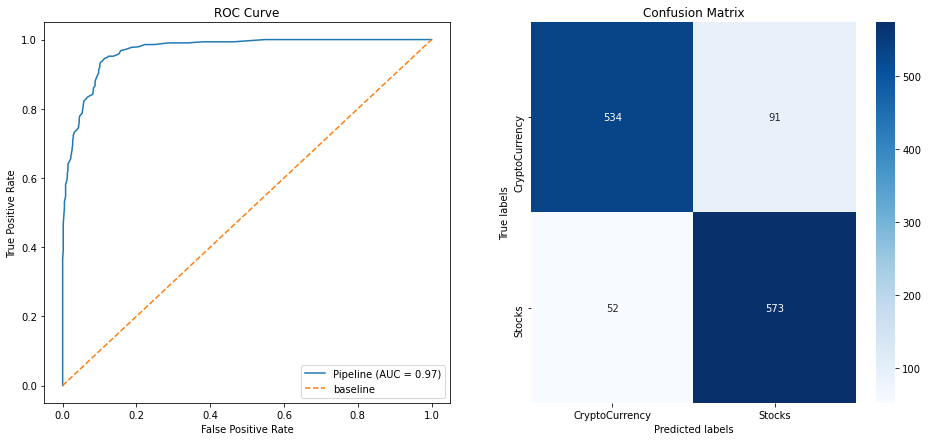

In [38]:
plot_model(rf_default_pipe, X_test, y_test)

In [39]:
add_model('Random Forest (default)', rf_default_pipe, X_test, y_test)

,F1 Score,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
Baseline,0.66667,1.0000,0.50000,625,625,0,0
Random Forest (default),0.88192,0.8544,0.96862,534,52,573,91


- Model performs better than the baseline for F1 score, however both the F1 score and recall are below 90%
- I will try tuning my random forest hyperparameters

### 1.3. Random Forest (HyperParameter Tuning)

- I will perform a gridsearch for the best hyperparameters for my random forest model tuning for the following hyperparameters:
 * 100, 250, or 500 trees
 * CountVectorizer or TfidVectorizer
 * Unigrams or bigrams included
- My gridsearch will choose the hyperparameters that give the best recall score

In [20]:
rf_pipe = Pipeline([('vec', None), 
                    ('rf', RandomForestClassifier())])

rf_param_grid = {'vec': [CountVectorizer(), TfidfVectorizer()], 
                 'rf__n_estimators':[100, 250, 500], 
                 'vec__stop_words': ["english"], 
                 'vec__ngram_range': [(1, 1), (1, 2)]}

rf_gs = GridSearchCV(rf_pipe, rf_param_grid, scoring = 'recall')

In [21]:
rf_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vec', None),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__n_estimators': [100, 250, 500],
                         'vec': [CountVectorizer(stop_words='english'),
                                 TfidfVectorizer()],
                         'vec__ngram_range': [(1, 1), (1, 2)],
                         'vec__stop_words': ['english']},
             scoring='recall')

In [40]:
display_f1(rf_gs,X_train, y_train, X_test, y_test)

Train F1 Score:  1.0
Test F1 Score:  0.92038
Cross Val F1 Score: 0.86593


- Random Forest with hyperparameter tuning does perform better on both the test set and the cross validation set than the default random forest, however the model is still overfitted

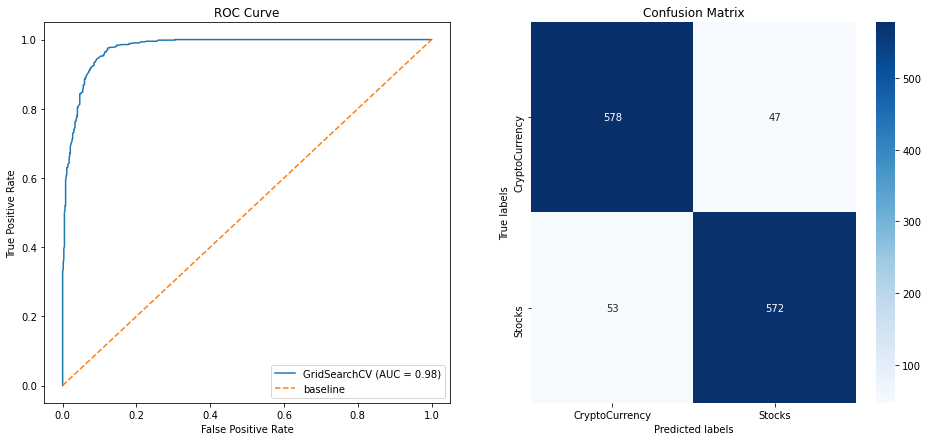

In [41]:
plot_model(rf_gs, X_test, y_test)

In [42]:
# display best params
rf_gs.best_params_

{'rf__n_estimators': 500,
 'vec': CountVectorizer(stop_words='english'),
 'vec__ngram_range': (1, 1),
 'vec__stop_words': 'english'}

- Even with hyperparamter tuning, the gridsearch has chosen hyperparameters that are actually very similar to the default 
- The two differences are that stop words have been removed in this model, and the number of trees is 500 instead of the default 100

In [43]:
add_model('Random Forest (tuned)', rf_gs, X_test, y_test)

,F1 Score,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
Baseline,0.66667,1.0000,0.50000,625,625,0,0
Random Forest (default),0.88192,0.8544,0.96862,534,52,573,91
Random Forest (tuned),0.92038,0.9248,0.97673,578,53,572,47


- Both the F1 score and recall are above 90%
- This model has performed better than the baseline and default random forest
- There is a significant improvement in the recall score by increasing the number of trees in the random forest from 100 to 500

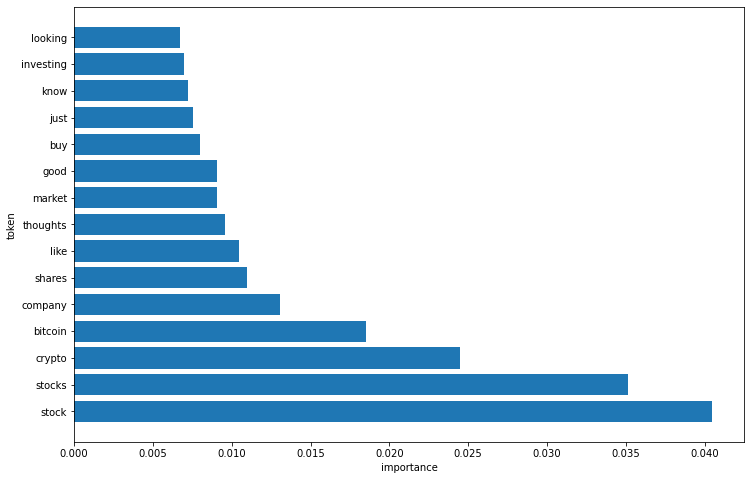

In [47]:
# plot tokens with the most importance
feat_weights = rf_gs.best_estimator_.named_steps['rf'].feature_importances_
rf_tokens = rf_gs.best_estimator_.named_steps['vec'].get_feature_names()

rf_feat = pd.DataFrame( {'top_words': rf_tokens, 'importance' : feat_weights})
rf_feat = rf_feat.set_index('top_words')
rf_feat = rf_feat.sort_values('importance',ascending = False)[:15]

plt.figure(figsize=(12,8))
plt.barh(rf_feat.index, rf_feat['importance'])
plt.xlabel('importance')
plt.ylabel('token')
plt.show();

- from the top 20 tokens, there are words I would expect would be good predictors of r/stocks and r/CryptoCurrency such as "stocks", "crypto", "bitcoin"
- it is interesting to see tokens such as "like", "thoughts", and "good" have a high importance in the random forest model

###  1.4. Multinomial Naive Bayes (Default)

In [48]:
# create pipe for cvec and multinomialNB

nb_default_pipe = Pipeline([
                ('cvec', CountVectorizer()),
                ('nb', MultinomialNB())
])

In [49]:
nb_default_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer()), ('nb', MultinomialNB())])

In [50]:
display_f1(nb_default_pipe,X_train, y_train, X_test, y_test)

Train F1 Score:  0.96912
Test F1 Score:  0.93556
Cross Val F1 Score: 0.89402


- The model shows less overfitting even using the default parameters than both random forest models

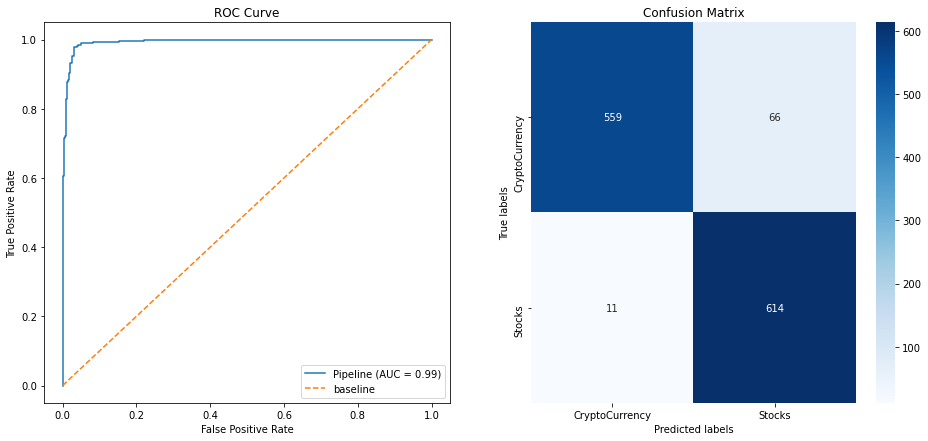

In [51]:
plot_model(nb_default_pipe, X_test, y_test)

In [52]:
add_model('MultinomialNB (default)', nb_default_pipe, X_test, y_test)

,F1 Score,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
Baseline,0.66667,1.0000,0.50000,625,625,0,0
Random Forest (default),0.88192,0.8544,0.96862,534,52,573,91
Random Forest (tuned),0.92038,0.9248,0.97673,578,53,572,47
MultinomialNB (default),0.93556,0.8944,0.99205,559,11,614,66


- The F1 score for the multinomial naive bayes model is higher than the random forest model, however, the recall is lower. 
- While the number of false positive is greatly reduced, the number of false negatives is slightly higher for this model
- The ROC AUC is 0.99, which means the model is able to distinguish between r/CryptoCurrency and r/stocks extremely well
- I will see if the recall can be improved with hyperparameter tuning

###  1.5. Multinomial Naive Bayes (HyperParameter Tuning)

In [53]:
nb_pipe = Pipeline([('vec', None), 
                    ('nb', MultinomialNB())])

nb_param_grid = {'vec': [CountVectorizer(), TfidfVectorizer()], 
                 'vec__stop_words': [None, 'english'], 
                 'vec__ngram_range': [(1, 1), (1, 2)],
                 'vec__max_features': [None, 1500, 3000, 5000]}

nb_gs = GridSearchCV(nb_pipe, nb_param_grid, scoring = 'recall')

In [54]:
nb_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vec', None), ('nb', MultinomialNB())]),
             param_grid={'vec': [CountVectorizer(max_features=5000),
                                 TfidfVectorizer()],
                         'vec__max_features': [None, 1500, 3000, 5000],
                         'vec__ngram_range': [(1, 1), (1, 2)],
                         'vec__stop_words': [None, 'english']},
             scoring='recall')

In [55]:
display_f1(nb_gs,X_train, y_train, X_test, y_test)

Train F1 Score:  0.94899
Test F1 Score:  0.93322
Cross Val F1 Score: 0.88779


- The train, test, and cross validation F1 scores are more similar than previous models
- This model is the least overfit from the models I have constructed so far

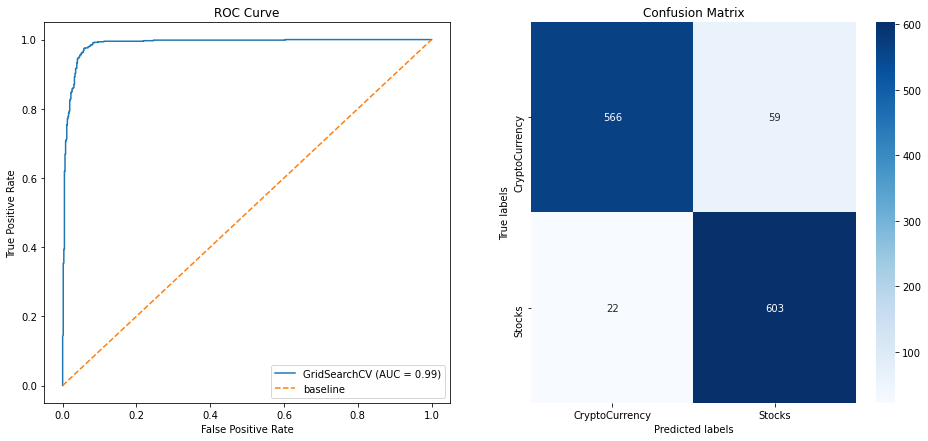

In [56]:
plot_model(nb_gs, X_test, y_test)

In [57]:
# display best params
nb_gs.best_params_

{'vec': CountVectorizer(max_features=5000),
 'vec__max_features': 5000,
 'vec__ngram_range': (1, 1),
 'vec__stop_words': None}

- Like the default model, the tuned multinomialNB model also used countvectorizer
- The only difference between the tuned multinomialNB model and the default is that the tuned model only took the top 5000 most frequent words in the corpus

In [59]:
add_model('MultinomialNB (tuned)', nb_gs, X_test, y_test)

,F1 Score,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
Baseline,0.66667,1.0000,0.50000,625,625,0,0
Random Forest (default),0.88192,0.8544,0.96862,534,52,573,91
Random Forest (tuned),0.92038,0.9248,0.97673,578,53,572,47
MultinomialNB (default),0.93556,0.8944,0.99205,559,11,614,66
MultinomialNB (tuned),0.93322,0.9056,0.98747,566,22,603,59


- The tuned multinomialNB has an F1 score and recall score above 90%, performing slightly better than the default multinomialNB for recall, and slightly worse for F1 score
- Both the tuned multinomialNB and tuned random forest have F1 scores and recall scores above 90%, however, the random forest has a slightly lower F1 score and the multinomialNB has a slightly lower recall

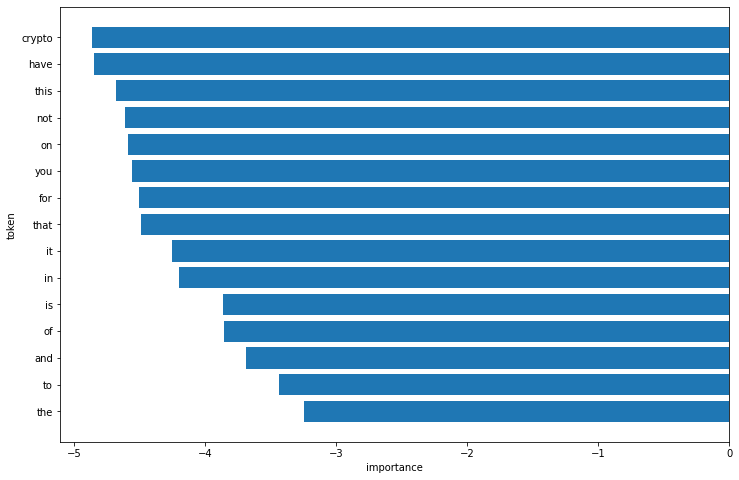

In [60]:
# plot tokens with highest coefficients
nb_coef = nb_gs.best_estimator_.named_steps['nb'].coef_[0]
nb_tokens = nb_gs.best_estimator_.named_steps['vec'].get_feature_names()

nb_feat = pd.DataFrame( {'top_words': nb_tokens, 'importance' : nb_coef})

nb_feat = nb_feat.set_index('top_words')
nb_feat = nb_feat.sort_values('importance',ascending = False)[:15]

plt.figure(figsize=(12,8))
plt.barh(nb_feat.index, nb_feat['importance'])
plt.xlabel('importance')
plt.ylabel('token')
plt.show();

- Since this model did not use stop words, it is interesting that many stop words seem to have high importance in predicting which subreddit a post belongs to
- The only token from thisl list which would seem to obviously predict r/CryptoCurrency is "crypto"

### 1.6. Support Vector Classifier

In [61]:
svc_pipe = Pipeline([('vec', None), 
                    ('svc', SVC(probability = True))])
svc_param_grid = {'vec': [CountVectorizer(), TfidfVectorizer()], 
                 'vec__stop_words': ['english'], 
                 'vec__ngram_range': [(1, 1), (1, 2)],
                 'svc__kernel': ['linear','rbf', 'sigmoid']}

svc_gs = GridSearchCV(svc_pipe, svc_param_grid, scoring = 'recall')

In [62]:
svc_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vec', None),
                                       ('svc', SVC(probability=True))]),
             param_grid={'svc__kernel': ['linear', 'rbf', 'sigmoid'],
                         'vec': [CountVectorizer(ngram_range=(1, 2),
                                                 stop_words='english'),
                                 TfidfVectorizer()],
                         'vec__ngram_range': [(1, 1), (1, 2)],
                         'vec__stop_words': ['english']},
             scoring='recall')

In [63]:
display_f1(svc_gs,X_train, y_train, X_test, y_test)

Train F1 Score:  0.93387
Test F1 Score:  0.90501
Cross Val F1 Score: 0.86122


- Overfitting is less of an issue with the support vector classifer than the random forest models
- The F1 scores are lower for train, test, and cross validation compared to the multinomialNB model

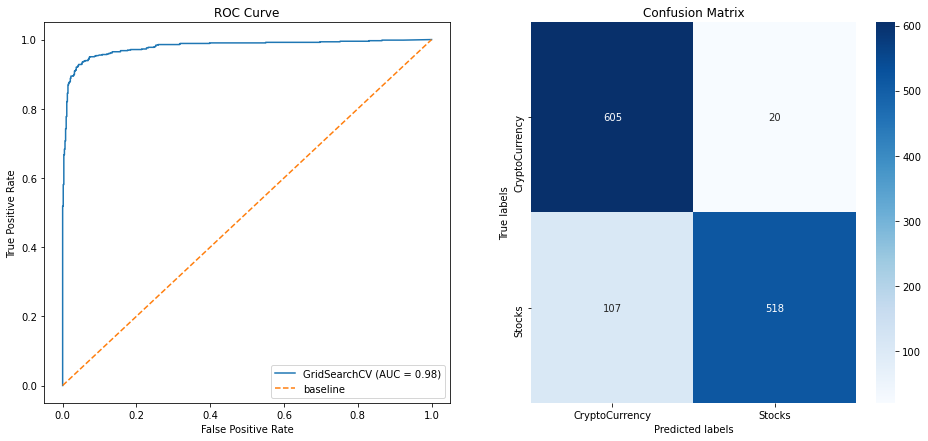

In [64]:
plot_model(svc_gs, X_test, y_test)

In [65]:
# display best parameters
svc_gs.best_params_

{'svc__kernel': 'sigmoid',
 'vec': CountVectorizer(ngram_range=(1, 2), stop_words='english'),
 'vec__ngram_range': (1, 2),
 'vec__stop_words': 'english'}

- Unlike the tuned multinomialNB model, the tuned SVC does use bigrams
- The SVC also used countvectorizer instead of TFidvectorizer, but unlike the multinomialNB this mode does not include stop words

In [66]:
add_model('SVC', svc_gs, X_test, y_test)

,F1 Score,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
Baseline,0.66667,1.0000,0.50000,625,625,0,0
Random Forest (default),0.88192,0.8544,0.96862,534,52,573,91
Random Forest (tuned),0.92038,0.9248,0.97673,578,53,572,47
MultinomialNB (default),0.93556,0.8944,0.99205,559,11,614,66
MultinomialNB (tuned),0.93322,0.9056,0.98747,566,22,603,59
SVC,0.90501,0.9680,0.97925,605,107,518,20


- The SVC model has an F1 score and recall above 90%
- The SVC actually has the highest recall score from all the models, while still mainting an F1 score above 90%
- I will see if I can boost the three best performing models (in terms of recall and F1 scores) using a voting classifier

### 1.7 Voting Classifier

In [67]:
vc = VotingClassifier(estimators=[('svc', svc_gs), 
                                    ('rf', rf_gs), 
                                    ('mnb', nb_gs)], 
                        voting='soft')
vc = vc.fit(X_train, y_train)

In [68]:
display_f1(vc,X_train, y_train, X_test, y_test)

Train F1 Score:  0.98837
Test F1 Score:  0.96672
Cross Val F1 Score: 0.93955


- This model has the highest cross validation score from all the models
- Compared to the previous models, the voting classifier has reduced the variance as the train, test, and cross validation F1 scores are similar

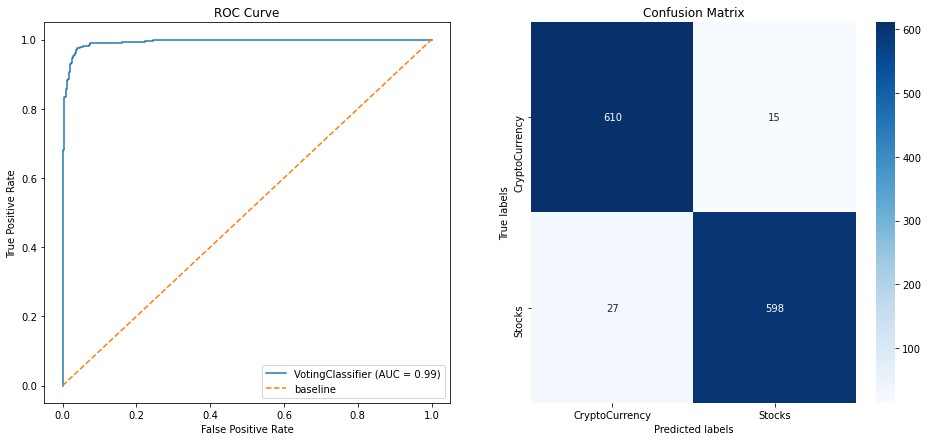

In [69]:
plot_model(vc, X_test, y_test)

In [70]:
add_model('Voting Classifier', vc, X_test, y_test)

,F1 Score,Recall,ROC AUC,True Positives,False Positives,True Negatives,False Negatives
Baseline,0.66667,1.0000,0.50000,625,625,0,0
Random Forest (default),0.88192,0.8544,0.96862,534,52,573,91
Random Forest (tuned),0.92038,0.9248,0.97673,578,53,572,47
MultinomialNB (default),0.93556,0.8944,0.99205,559,11,614,66
MultinomialNB (tuned),0.93322,0.9056,0.98747,566,22,603,59
SVC,0.90501,0.9680,0.97925,605,107,518,20
Voting Classifier,0.96672,0.9760,0.99302,610,27,598,15


- The voting classifier has the highest F1 score, recall, and ROC AUC from all the models
- The false negatives in this model is 15 from a test set of 1250
- The F1 score is 97% and the recall is 98%, which are both above 90% => therefore I am comfortable using this model to predict whether or not a post belongs to the r/CryptoCurrency subreddit

## 2. Conclusion and Recommendations

### 2.1. Final Model



The goal of this project was to build a binary classification model that could be used to predict if a post on reddit belongs to r/CryptoCurrency or r/stocks. 

The final model is a voting classifier that uses a random forest classifier, multinomial naive Bayes, and support vector classifier to predict the subreddit based on the text in a given post. This model has an F1 score of 97% and a recall score of 98%, and would therefore be considered successful.  One of the strengths of this model is that it has been trained with over a year’s worth of data, therefore it is less skewed towards hot topics/latest news fluctuations. For example, if the dataset only contained data from the week when El Salvador announced they would adopt bitcoin as legal tender, the model may place too much importance on “El Salvador”, and may incorrectly predict only posts related to El Salvador as posts about cryptocurrency. By training the model with over a year’s worth of data, the model should be able to classify a broader range of posts with a higher accuracy. 

CryptoGo will be able to use this model to show their advertisement on posts that are most relevant to cryptocurrency. If CryptoGo wants to spend 2000 dollars on its reddit advertising campaign and every advertisement placement on reddit costs 1 dollar, ideally they would want to spend 2000 dollars on posts that users interested in cryptocurrency would see. If they were to target random posts in the r/Stocks and r/CryptoCurrency, they would spend approximately 1000 dollars on the correct audience, and approximately 1000 dollars on the wrong audience. Instead, if CryptoGo used this model to only target posts they predicted are interested in cryptocurrency, they would spend 1,915 dollars on the correct audience, and only 85 dollars on the wrong audience (the false positive rate is 4.2%). This would save 915 dollars that was being allocated incorrectly to target the wrong audience.

### 2.2. Businness Recommendations

In addition to classifying posts for targeted marketing, the sentiment analysis can also be used to identify posts that have a higher positive polarity score and may therefore be more receptive to advertisements related to cryptocurrency products. For example, many of the posts with a high positive polarity score in r/CryptoCurrency are related to free money, or happiness, or see high potential in investing in cryptocurrency. Showing advertisements alongside such posts would bring in more customers than showing advertisements with posts that have high negative polarity scores, where many posts are concerned about being scammed or losing money through investing in cryptocurrency.  This may also be useful to note when planning the marketing strategy for CryptoGo - while the target audience is interested in earning “free” money or getting high returns, there is a concern that cryptocurrency products are high risk and maybe scams, so it would be important to assure potential customers through marketing that CryptoGo is a trustworthy company. 

CryptoGo also wanted to know key words and phrases that are unique among people interested in cryptocurrency when compared to other financial products such as stocks. Some of these key phrases are ‘hardware wallet’, ‘bitcoin mining’, and ‘smart contracts’.  It is also worth noting that two of the most frequent phrases in r/CryptoCurrency are “Saylor Academy” and “National Paralegal College”. Both institutions provide free online courses for people who are interested in learning more about cryptocurrency. As people who either post about or read posts about these courses are looking for resources to begin their cryptocurrency journey, it could be a good strategy to target marketing towards posts mentioning these institutions.

### 2.3. Further Steps

The purpose of this model in production is to be able to identify posts that are similar to posts in r/CryptoCurrency across other subreddits. This will help CryptoGo to target their marketing to other active subreddits that have a similar interest in cryptocurrency, and would therefore be more likely to invest with CryptoGo.  In order to make the model more robust, it would be good to train the model on other (both financial and non-financial) subreddits as well, so that the model is better at predicting cryptocurrency related posts against a variety of other posts. 
Depending on how the marketing campaign on Reddit is received, the model could also be trained on other social media platforms to expand CryptoGo’s marketing to platforms such as YoutTube or Instagram. Additionally, training the model on cryptocurrency related news articles may help the model to identify posts linked to current events that are also relevant to cryptocurrency.